#Класифікація мінералів за допомогою Inception

In [1]:
import os
import shutil
import random
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.applications import InceptionV3
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import zipfile

# Розархівування набору даних
local_zip = './minerals.zip'  # Назва вашого архіву
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./base_minerals')  # Шлях для розархівованих даних
zip_ref.close()


In [3]:
import os
import shutil
import random

# Шляхи до вихідного і цільового набору даних
original_dataset_dir = './base_minerals/minerals'
base_dir = 'minerals_gen'

# Створення папок для train, validation та test
os.makedirs(base_dir, exist_ok=True)
for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_name in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Функція для розподілу файлів по вибірках
def split_data(class_dir, train_dir, val_dir, test_dir):
    files = os.listdir(class_dir)

    train_split = int(len(files) * 0.8)
    val_split = int(len(files) * 0.9)

    train_files = files[:train_split]
    val_files = files[train_split:val_split]
    test_files = files[val_split:]

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), train_dir)
    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), val_dir)
    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), test_dir)

# Розподіл файлів для кожного класу
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_dir):
        split_data(
            class_dir,
            os.path.join(base_dir, 'train', class_name),
            os.path.join(base_dir, 'validation', class_name),
            os.path.join(base_dir, 'test', class_name)
        )

print("Файли успішно розподілені на вибірки!")

Файли успішно розподілені на вибірки!


In [4]:
#Підготовка генераторів даних
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=45, width_shift_range=0.3,
                                   height_shift_range=0.3, shear_range=0.3, zoom_range=0.3,
                                   horizontal_flip=True, fill_mode='nearest')

datagen = ImageDataGenerator(rescale=1.0/255)

img_width, img_height = 299, 299

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical'
)

Found 758 images belonging to 7 classes.
Found 95 images belonging to 7 classes.
Found 99 images belonging to 7 classes.


In [5]:
# Визначаємо кількість класів
class_names = ['biotite', 'bornite', 'chrysocolla', 'malachite', 'muscovite',
               'pyrite', 'quartz']
classes_num = len(class_names)

# Завантаження базової моделі InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Розморожування базової частини моделі
conv_base.trainable = True

# Заморожуємо частину базових шарів (наприклад, перші 200 шарів)
for layer in conv_base.layers[:200]:
    layer.trainable = False

# Побудова моделі
x = layers.GlobalAveragePooling2D()(conv_base.output)
x = layers.Dense(1024, activation='relu')(x)  # Додатковий повнозв'язний шар
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(classes_num, activation='softmax')(x)

model = Model(inputs=conv_base.input, outputs=x)

# Компіляція моделі з новими налаштуваннями
model.compile(
    loss='categorical_crossentropy',
    optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4),
    metrics=['accuracy']
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Навчання моделі з частково розмороженою базовою частиною
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

model.save('minerals_classification_EXP5.h5')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.4008 - loss: 1.7356 - val_accuracy: 0.3895 - val_loss: 13.3233
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 459ms/step - accuracy: 0.6534 - loss: 0.9100 - val_accuracy: 0.5789 - val_loss: 4.0188
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 461ms/step - accuracy: 0.8101 - loss: 0.6210 - val_accuracy: 0.3053 - val_loss: 25.0247
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 475ms/step - accuracy: 0.7815 - loss: 0.6216 - val_accuracy: 0.6000 - val_loss: 3.6872
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 475ms/step - accuracy: 0.7737 - loss: 0.7360 - val_accuracy: 0.7789 - val_loss: 0.6525
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 474ms/step - accuracy: 0.7991 - loss: 0.6291 - val_accuracy: 0.8105 - val_loss: 0.9311
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 442ms/step - accuracy: 0.8728 - loss: 0.3946 - val_accuracy: 0.8000 - val_loss: 0.9587
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 470ms/step - accuracy: 0.8648 - loss: 0.4187 - val_accuracy: 0.842

In [7]:
# Оцінка моделі на тестових даних
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Тестова втрата: {test_loss:.4f}")
print(f"Тестова точність: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.8204 - loss: 0.4212
Тестова втрата: 0.5946
Тестова точність: 0.8021


In [8]:
# Оцінка моделі на тестових даних
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"Валідаційна втрата: {val_loss:.4f}")
print(f"Валідаційна точність: {val_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8767 - loss: 0.3010
Валідаційна втрата: 0.3393
Валідаційна точність: 0.8737


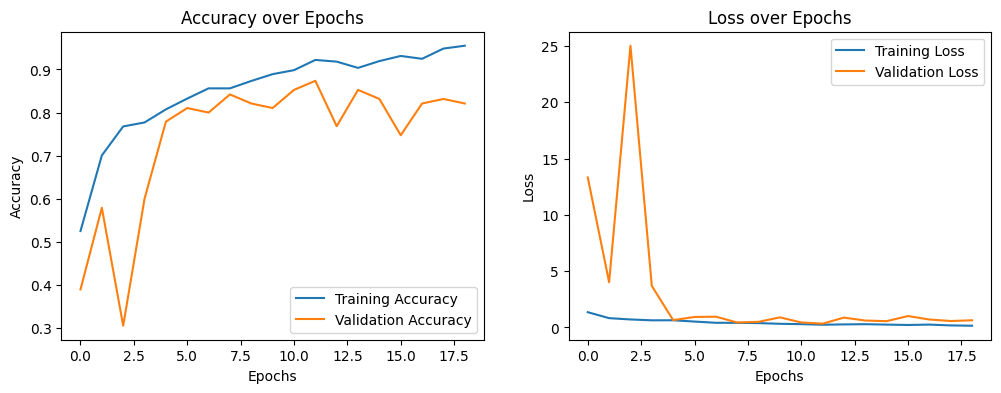

In [9]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()